In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Install & Import

In [ ]:
!pip install category_encoders

In [ ]:
!pip install eli5

In [ ]:
!pip install shap

In [6]:
import torch
import numpy as np
import os

def seed_everything(seed=42):
    """"
    Seed everything.
    """   
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
import random


from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot
from lightgbm import plot_importance as lgbm_plot

import eli5
from eli5.sklearn import PermutationImportance

import shap
import skimage

plt.style.use('ggplot')

In [8]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

In [9]:
df_train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [11]:
df_train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [13]:
df_test.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

* We can see that there are some null values and mixed feature dtype(category, continuous)
* Even in test dataset, there are some null values... what.. 
* So we have to add some codes for null values in test data (if.. null~~ ) with each column
* Therefore, this dataset's EDA for get some insight about data is particularly important!!!!!
* The Target column is "Segmentation"

# dtype Change

In [14]:
## The column 'Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1' and 'Segmentation' is Categorical Data
## So I encoded them by LabelEncoder for Visualizatin 
## Indeed, I found that Family_size and Work_Experience Columns are categorical data as a matter of fact so I include it to category_col 

df_train['Family_Size'] = df_train['Family_Size'].astype('object')
df_test['Family_Size'] = df_test['Family_Size'].astype('object')

df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

## Remove ID column
df_train.drop('ID', axis=1, inplace=True)
df_test.drop('ID', axis=1, inplace=True)


# Visualizatin

### Check Distributions

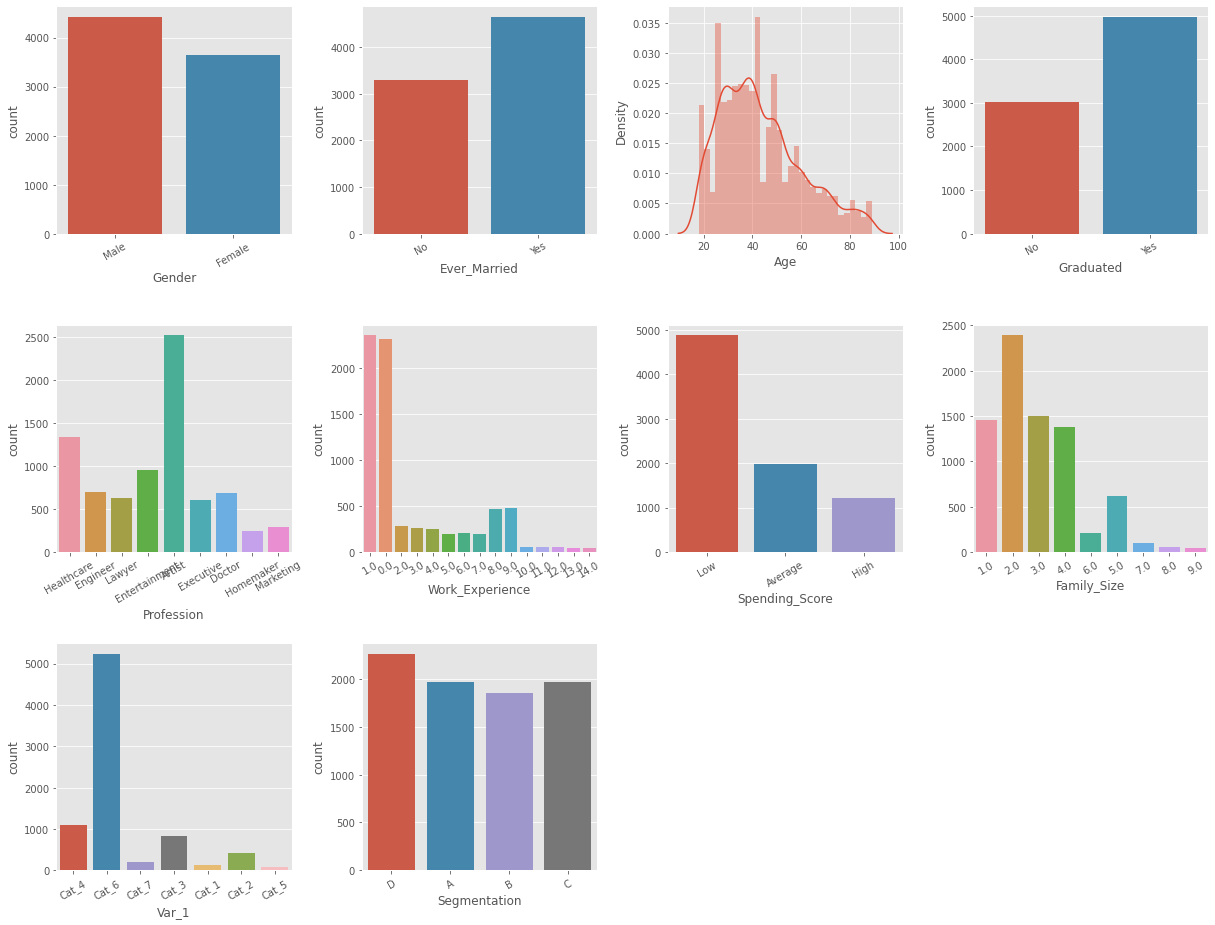

In [15]:
columns = df_train.columns ## There are 11 columns

fig, axes = plt.subplots(3,4, figsize=(20,15))
axes = axes.ravel()

for idx, i in enumerate(columns) :
    ## dtype 별로 나눠서 category 면 Count plot , 연속형이면 distplot
    if df_train[i].dtype == 'int64' :
        sns.distplot(df_train[i], ax = axes[idx])
        

    elif df_train[i].dtype == 'O' :
        sns.countplot(df_train[i], ax = axes[idx])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(),rotation = 30)



axes[-2].remove()    
axes[-1].remove()

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()

* Except ID column, I found that almost column is Categorical Data....

### Check Correlatins

In [16]:
## for corr Check, we are going to drop null rows for right now.... 
df_dropna = df_train.dropna(axis=0)


In [17]:
## Change by Label Encoder

category_col = ['Gender','Ever_Married','Graduated','Profession','Spending_Score','Var_1','Family_Size','Work_Experience', 'Segmentation']

for i in category_col :
    le = LabelEncoder()
    df_dropna[i] = le.fit_transform(df_dropna[i])


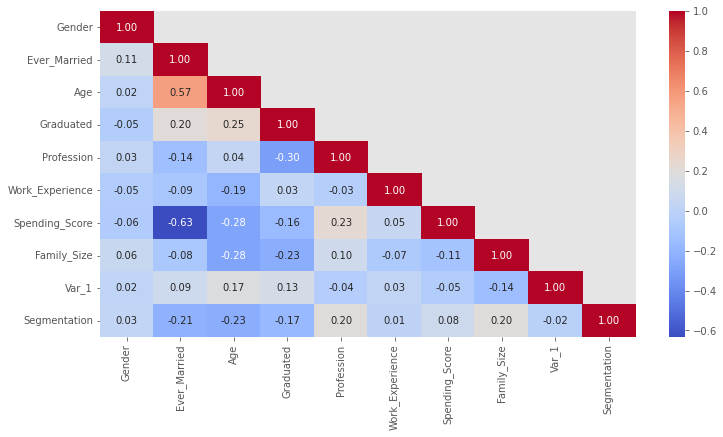

In [18]:
mat = df_dropna.corr()
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(mat, annot = True, fmt='.2f', cmap='coolwarm', mask = np.triu(mat,1))
plt.show()

* Almost Columns are have low corr with Target Variation. SO I think we have to fill the missing values.. This is because it has a missing value ratio of as much as 10% but we have few datas...


## Check Missng Values

* Especially, 'Ever_Married' and 'Age','Graduated','Profession','Family_size' columns are seems like they need fill missing values because they have relatively large correlation. 
  
   
* And I decided to implement two way about missing values  
    - Depending on 'use_missing' parameter of LGBM & XGBoost 
    - Replace with mode (Because almost missing values are categorical datas..)

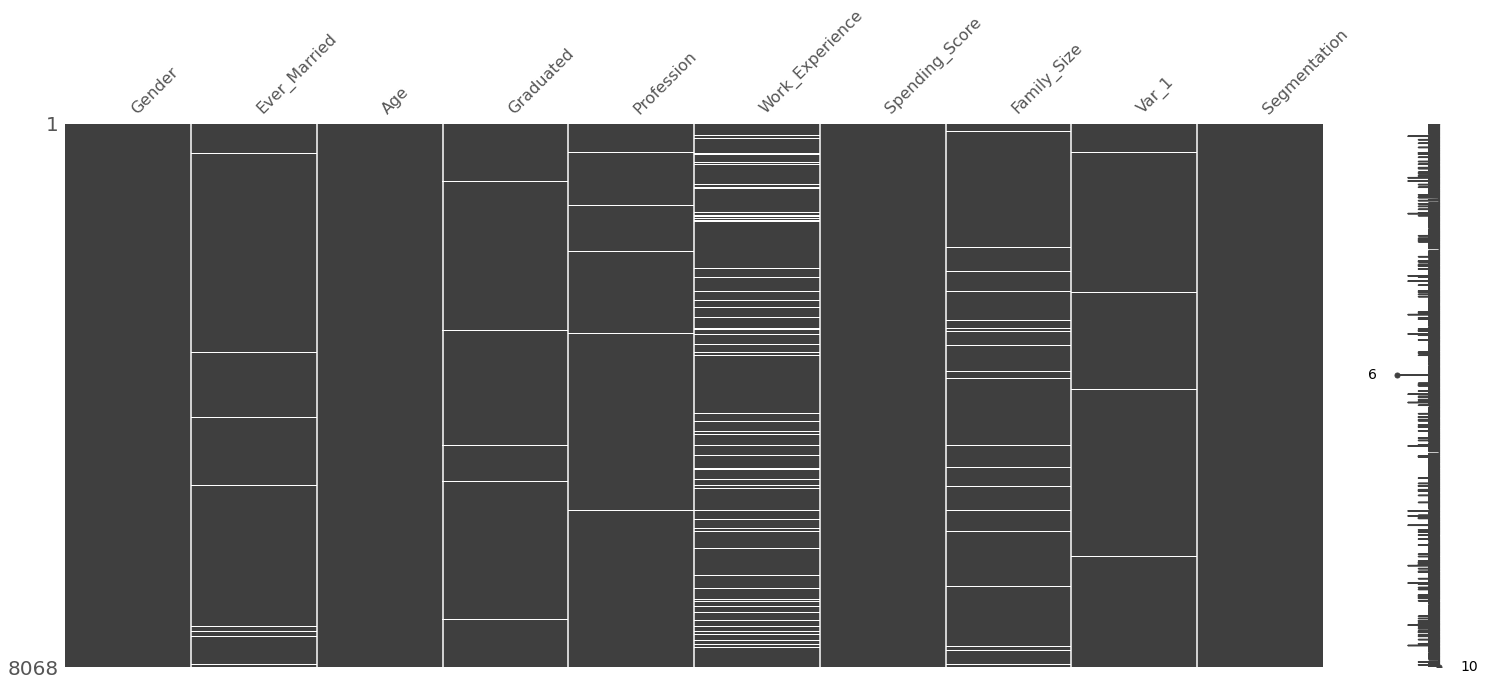

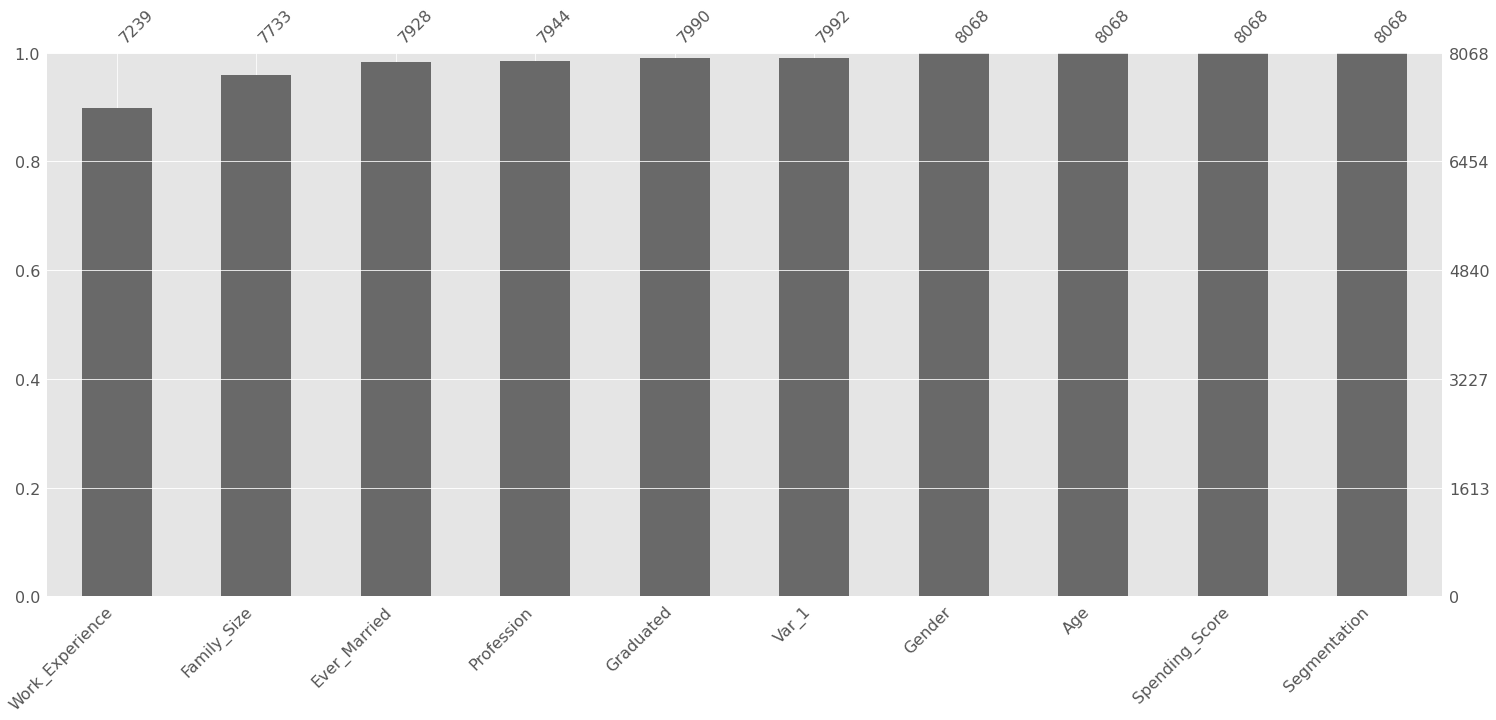

In [19]:
import missingno as msno

msno.matrix(df_train)
plt.show()

msno.bar(df_train,  sort='ascending')
plt.show()

## Check Outliers (Age Column)


71


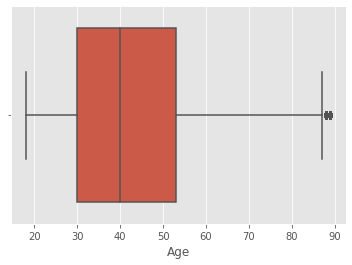

In [20]:
## make outlier finder function

def hello_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][(df[column] < lowest) |
                             (df[column] > highest)].index
    return outlier_idx

outlier_idx = hello_outlier(df= df_train, column='Age')
print(len(outlier_idx)) ## 71 outliers are in Age column

sns.boxplot(df_train['Age'])
plt.show()

* But I decided not to delete outliers because that variant is have relatively strong corr...

# Filling Missing Valuse



## Method 1 - Filling with mode value

In [21]:
## Train Dataset

df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

df_train['Family_Size'] = df_train['Family_Size'].astype('object')
df_test['Family_Size'] = df_test['Family_Size'].astype('object')

df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

## Remove ID column
df_train.drop('ID', axis=1, inplace=True)
df_test.drop('ID', axis=1, inplace=True)

be_value = {}

for i in df_train.columns :    
    mode_value = df_train[i].mode()[0]
    be_value[i] = mode_value

df_train.fillna(value = be_value, inplace = True)

In [22]:
## Test Dataset

be_value = {}

for i in df_test.columns :
    mode_value = df_test[i].mode()[0]
    be_value[i] = mode_value

df_test.fillna(value = be_value, inplace = True)

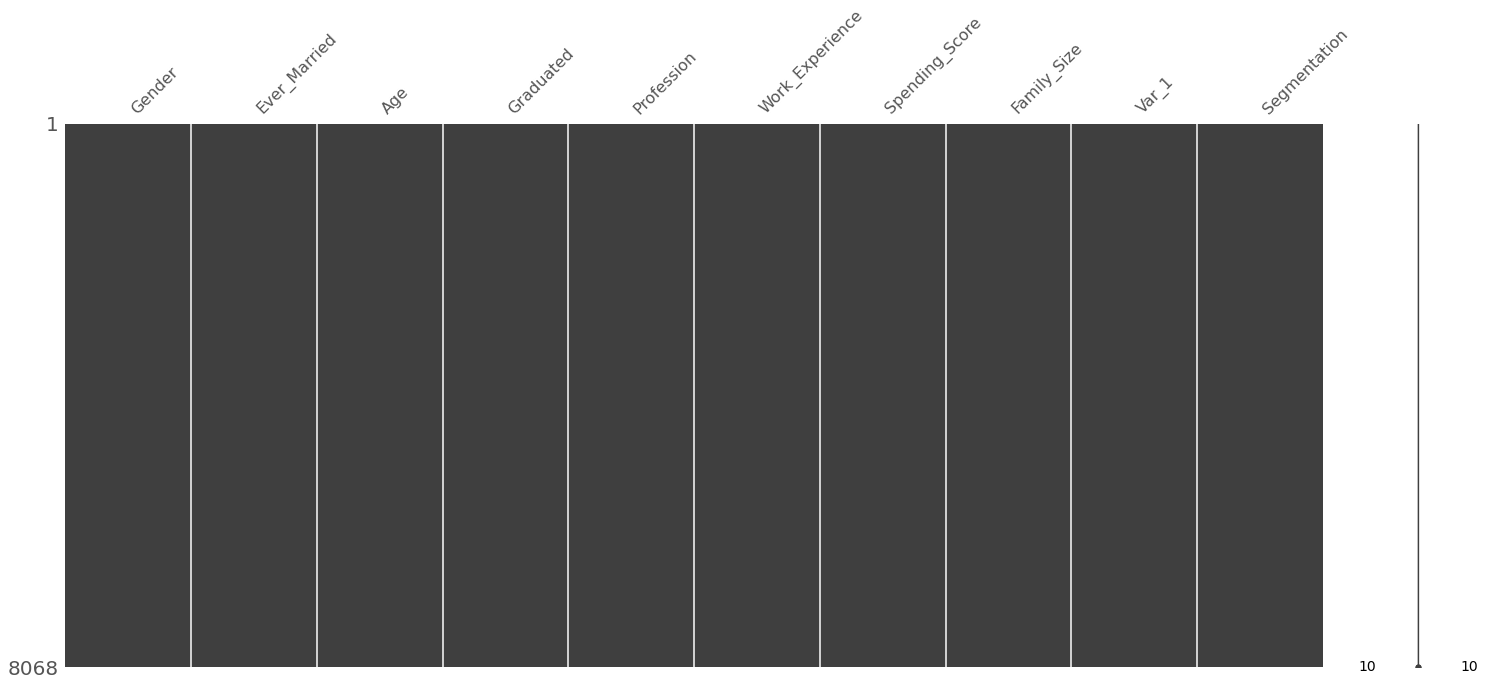

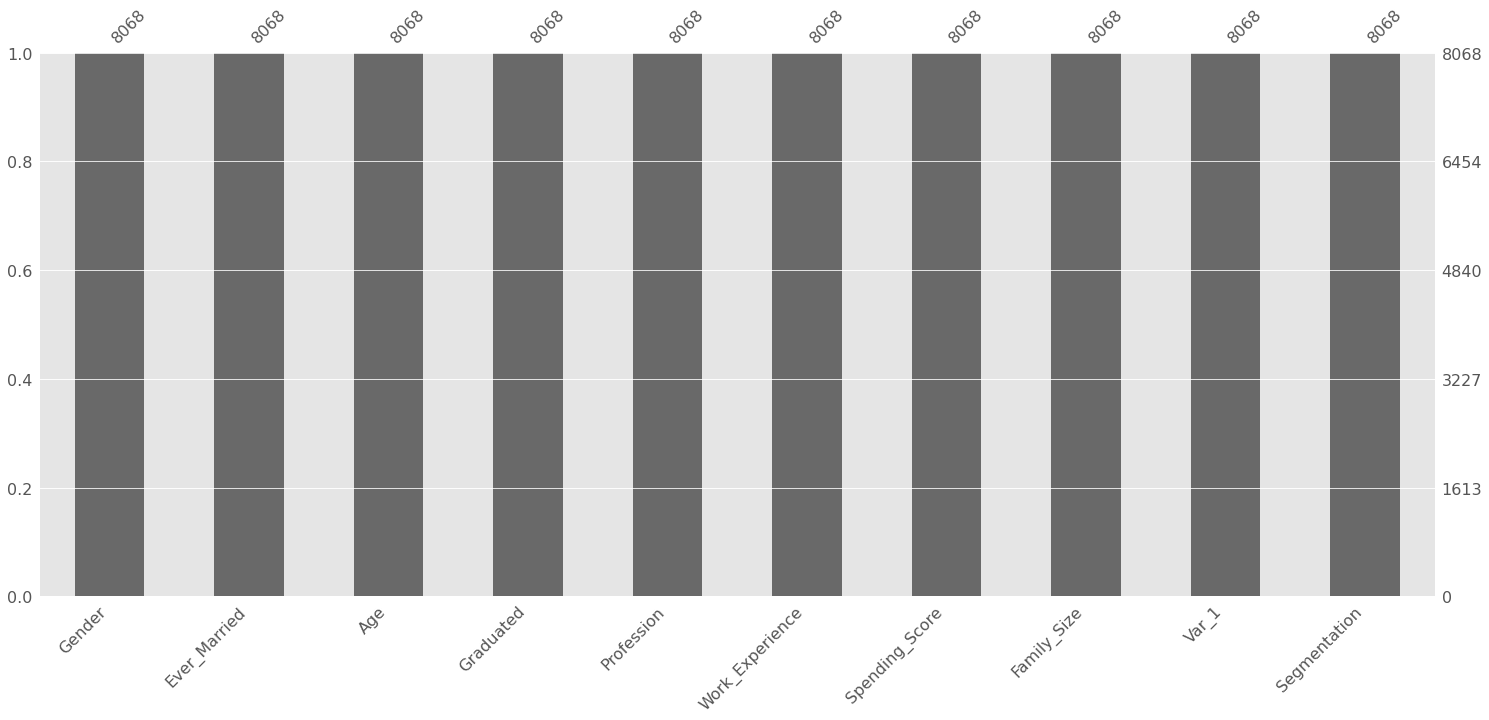

In [23]:
msno.matrix(df_train)
plt.show()

msno.bar(df_train,  sort='ascending')
plt.show()

### Encoder
* Categorical data with sequential meaning : Ordinal Encoder
* Categorical data with non-sequential meaning : OneHot Encoder 

In [24]:
from category_encoders import OneHotEncoder


### Train Data ###
seq_cols = ['Work_Experience','Family_Size','Spending_Score'] ## including Target Variable
non_seq_cols = ['Gender','Ever_Married','Graduated','Profession','Var_1']

## oe Encoder
df_oe_tr = df_train[seq_cols]
oe = OrdinalEncoder()
df_oe_tr = oe.fit_transform(df_oe_tr)
df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

## for target data Encoding
target_oe = OrdinalEncoder()
oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])

## ohe Encoder
df_ohe_tr = df_train[non_seq_cols]
ohe = OneHotEncoder(use_cat_names = True)
df_ohe_tr = ohe.fit_transform(df_ohe_tr)

### Scaler (MinMaxScaler)

In [25]:
mm = MinMaxScaler()
scd_age_tr = mm.fit_transform(df_train[['Age']])
scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

scd_age_test = mm.transform(df_test[['Age']])
scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])

In [26]:
seq_cols = ['Work_Experience','Family_Size','Spending_Score'] 
non_seq_cols = ['Gender','Ever_Married','Graduated','Profession','Var_1']


### Test Data ###
## oe Encoder
df_oe_test = df_test[seq_cols]
df_oe_test = oe.transform(df_oe_test)
df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

## ohe Encoder
df_ohe_test = df_test[non_seq_cols]
df_ohe_test = ohe.transform(df_ohe_test)

In [27]:
fin_df_train = pd.concat([df_oe_tr,df_ohe_tr,scd_age_tr ,oe_target_tr], axis=1)
fin_df_train

,Work_Experience,Family_Size,Spending_Score,Gender_Male,Gender_Female,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Healthcare,...,Profession_Marketing,Var_1_Cat_4,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_3,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_5,Age,Segmentation
0,1,3,2,1,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0.056338,3.0
1,1,2,0,0,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0.281690,0.0
2,1,0,2,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0.690141,1.0
3,0,1,1,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0.690141,1.0
4,1,5,1,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0.309859,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,0,6,2,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0.056338,3.0
8064,3,3,2,1,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0.239437,3.0
8065,1,0,2,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0.211268,3.0
8066,1,3,2,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0.126761,1.0


In [28]:
fin_df_test = pd.concat([df_oe_test,df_ohe_test, scd_age_test], axis=1)
fin_df_test

,Work_Experience,Family_Size,Spending_Score,Gender_Male,Gender_Female,Ever_Married_No,Ever_Married_Yes,Graduated_No,Graduated_Yes,Profession_Healthcare,...,Profession_Homemaker,Profession_Marketing,Var_1_Cat_4,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_3,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_5,Age
0,0,0,2,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0.253521
1,8,3,0,1,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0.267606
2,0,0,2,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0.718310
3,11,1,1,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0.577465
4,1,3,2,0,1,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0.014085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,9,3,2,1,0,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0.154930
2623,1,0,2,0,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.239437
2624,1,1,2,0,1,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.492958
2625,1,4,1,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0.408451


### Classifier 
* I use LGBM Classifier because this is a dataset that have target value
* And LGBM is partially proved to perform better than DL Models in Tabular Data



In [ ]:
features = fin_df_train.drop(['Segmentation'], axis=1)
target = fin_df_train['Segmentation']


lgbm_clf = LGBMClassifier() ## use default parameters to test our pre-processing and feature importance

scores = cross_val_score(lgbm_clf, features, target, cv=5, scoring='accuracy' )

print(f'Mean Score : {np.mean(scores)*100:.2f}%')



## Method 2 - Filling with mode&OE

In [30]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

df_train['Family_Size'] = df_train['Family_Size'].astype('object')
df_test['Family_Size'] = df_test['Family_Size'].astype('object')

df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

## Remove ID column
df_train.drop('ID', axis=1, inplace=True)
df_test.drop('ID', axis=1, inplace=True)




In [31]:
## Train Dataset

be_value = {}

for i in df_train.columns :    
    mode_value = df_train[i].mode()[0]
    be_value[i] = mode_value

df_train.fillna(value = be_value, inplace = True)

In [32]:
## Test Dataset

be_value = {}

for i in df_test.columns :
    mode_value = df_test[i].mode()[0]
    be_value[i] = mode_value

df_test.fillna(value = be_value, inplace = True)

### Encoder

In [33]:
from category_encoders import OneHotEncoder


### Train Data ###
seq_cols = ['Work_Experience','Family_Size','Spending_Score','Gender','Ever_Married','Graduated','Profession','Var_1']

## oe Encoder
df_oe_tr = df_train[seq_cols]
oe = OrdinalEncoder()
df_oe_tr = oe.fit_transform(df_oe_tr)
df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

## for target data Encoding
target_oe = OrdinalEncoder()
oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])

## ohe Encoder
df_ohe_tr = df_train[non_seq_cols]
ohe = OneHotEncoder(use_cat_names = True)
df_ohe_tr = ohe.fit_transform(df_ohe_tr)

In [34]:

### Test Data ###
## oe Encoder
df_oe_test = df_test[seq_cols]
df_oe_test = oe.transform(df_oe_test)
df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

### Scaler

In [35]:
mm = MinMaxScaler()
scd_age_tr = mm.fit_transform(df_train[['Age']])
scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

scd_age_test = mm.transform(df_test[['Age']])
scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])

In [36]:
fin_df_train = pd.concat([df_oe_tr,scd_age_tr ,oe_target_tr], axis=1)
fin_df_train

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age,Segmentation
0,1,3,2,1,0,0,5,3,0.056338,3.0
1,1,2,0,0,1,1,2,3,0.281690,0.0
2,1,0,2,0,1,1,2,5,0.690141,1.0
3,0,1,1,1,1,1,7,5,0.690141,1.0
4,1,5,1,0,1,1,3,5,0.309859,0.0
...,...,...,...,...,...,...,...,...,...,...
8063,0,6,2,1,0,0,0,0,0.056338,3.0
8064,3,3,2,1,0,0,4,3,0.239437,3.0
8065,1,0,2,0,0,1,5,5,0.211268,3.0
8066,1,3,2,0,0,1,5,5,0.126761,1.0


In [37]:
fin_df_test = pd.concat([df_oe_test, scd_age_test], axis=1)
fin_df_test

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age
0,0,0,2,0,1,1,2,5,0.253521
1,8,3,0,1,1,1,5,5,0.267606
2,0,0,2,0,1,0,0,5,0.718310
3,11,1,1,1,1,0,4,5,0.577465
4,1,3,2,0,0,0,8,5,0.014085
...,...,...,...,...,...,...,...,...,...
2622,9,3,2,1,0,0,5,5,0.154930
2623,1,0,2,0,0,1,1,5,0.239437
2624,1,1,2,0,0,1,3,5,0.492958
2625,1,4,1,1,1,1,4,3,0.408451


### Classifier 

In [ ]:
features = fin_df_train.drop(['Segmentation'], axis=1)
target = fin_df_train['Segmentation']


lgbm_clf = LGBMClassifier() ## use default parameters to test our pre-processing and feature importance

scores = cross_val_score(lgbm_clf, features, target, cv=5, scoring='accuracy' )

print(f'Mean Score : {np.mean(scores)*100:.2f}%')

## Method 3 - Drop Them & OE

In [39]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

df_train['Family_Size'] = df_train['Family_Size'].astype('object')
df_test['Family_Size'] = df_test['Family_Size'].astype('object')

df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

## Remove ID column
df_train.drop('ID', axis=1, inplace=True)
df_test.drop('ID', axis=1, inplace=True)




In [40]:
## Train Dataset

df_train = df_train.dropna()

In [41]:
## Test Dataset

df_test = df_test.dropna()

### Encoder

In [42]:
from category_encoders import OneHotEncoder


### Train Data ###
seq_cols = ['Work_Experience','Family_Size','Spending_Score','Gender','Ever_Married','Graduated','Profession','Var_1']

## oe Encoder
df_oe_tr = df_train[seq_cols]
oe = OrdinalEncoder()
df_oe_tr = oe.fit_transform(df_oe_tr)
df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

## for target data Encoding
target_oe = OrdinalEncoder()
oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])


In [43]:

### Test Data ###
## oe Encoder
df_oe_test = df_test[seq_cols]
df_oe_test = oe.transform(df_oe_test)
df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

### Scaler

In [44]:
mm = MinMaxScaler()
scd_age_tr = mm.fit_transform(df_train[['Age']])
scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

scd_age_test = mm.transform(df_test[['Age']])
scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])

In [45]:
fin_df_train = pd.concat([df_oe_tr, scd_age_tr ,oe_target_tr], axis=1)
fin_df_train

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age,Segmentation
0,1,3,2,1,0,0,5,3,0.056338,3.0
1,1,0,2,0,1,1,2,5,0.690141,1.0
2,0,1,1,1,1,1,7,5,0.690141,1.0
3,0,1,0,1,1,0,0,5,0.535211,2.0
4,1,2,2,1,0,1,5,5,0.197183,2.0
...,...,...,...,...,...,...,...,...,...,...
6660,0,4,1,1,1,1,0,5,0.323944,1.0
6661,3,3,2,1,0,0,4,3,0.239437,3.0
6662,1,0,2,0,0,1,5,5,0.211268,3.0
6663,1,3,2,0,0,1,5,5,0.126761,1.0


In [46]:
fin_df_test = pd.concat([df_oe_test, scd_age_test], axis=1)
fin_df_test

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age
0,0,0,2,0,1,1,2,5,0.253521
1,8,3,0,1,1,1,5,5,0.267606
2,11,1,1,1,1,0,4,5,0.577465
3,0,4,1,1,1,1,1,3,0.408451
4,5,2,2,1,1,1,1,5,0.605634
...,...,...,...,...,...,...,...,...,...
2149,1,1,2,0,0,1,3,5,0.239437
2150,9,3,2,1,0,0,5,5,0.154930
2151,1,0,2,0,0,1,1,5,0.239437
2152,1,4,1,1,1,1,4,3,0.408451


### Classifier 

In [ ]:
features = fin_df_train.drop(['Segmentation'], axis=1)
target = fin_df_train['Segmentation']


lgbm_clf = LGBMClassifier() ## use default parameters to test our pre-processing and feature importance

scores = cross_val_score(lgbm_clf, features, target, cv=5, scoring='accuracy' )

print(f'Mean Score : {np.mean(scores)*100:.2f}%')

# Interim Summary - 1
* 3 Methods shows almost same performance so I choose Method 1  
 Because 'in data perspective', I think it is more proper to encode datas differently in accoding to data type   
 EX)   
 Category - Ordinal : OrdinalEncoding,   
 Category - Non Ordinal : OneHotEncoding

In [48]:
def preprocessing (df_train=None, df_test=None) :
    ## Train Dataset

    df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
    df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

    df_train['Family_Size'] = df_train['Family_Size'].astype('object')
    df_test['Family_Size'] = df_test['Family_Size'].astype('object')

    df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
    df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

    ## Remove ID column
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1, inplace=True)

    be_value = {}

    for i in df_train.columns :    
        mode_value = df_train[i].mode()[0]
        be_value[i] = mode_value

    df_train.fillna(value = be_value, inplace = True)

    ## Test Dataset

    be_value = {}

    for i in df_test.columns :
        mode_value = df_test[i].mode()[0]
        be_value[i] = mode_value

    df_test.fillna(value = be_value, inplace = True)


    ### Train Data ###
    seq_cols = ['Family_Size','Spending_Score'] ## including Target Variable
    non_seq_cols = ['Graduated','Profession','Var_1']

    ## oe Encoder
    df_oe_tr = df_train[seq_cols]
    oe = OrdinalEncoder()
    df_oe_tr = oe.fit_transform(df_oe_tr)
    df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

    ## for target data Encoding
    target_oe = OrdinalEncoder()
    oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
    oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])

    from category_encoders import OneHotEncoder

    ## ohe Encoder
    df_ohe_tr = df_train[non_seq_cols]
    ohe = OneHotEncoder(use_cat_names = True)
    df_ohe_tr = ohe.fit_transform(df_ohe_tr)

    mm = MinMaxScaler()
    scd_age_tr = mm.fit_transform(df_train[['Age']])
    scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

    scd_age_test = mm.transform(df_test[['Age']])
    scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])


    seq_cols = ['Family_Size','Spending_Score'] 
    non_seq_cols = ['Graduated','Profession','Var_1']


    ### Test Data ###
    ## oe Encoder
    df_oe_test = df_test[seq_cols]
    df_oe_test = oe.transform(df_oe_test)
    df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

    ## ohe Encoder
    df_ohe_test = df_test[non_seq_cols]
    df_ohe_test = ohe.transform(df_ohe_test)

    fin_df_train = pd.concat([df_oe_tr,df_ohe_tr,scd_age_tr ,oe_target_tr], axis=1)
    fin_df_test = pd.concat([df_oe_test,df_ohe_test, scd_age_test], axis=1)

    return fin_df_train, fin_df_test

In [49]:
fin_df_train

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age,Segmentation
0,1,3,2,1,0,0,5,3,0.056338,3.0
1,1,0,2,0,1,1,2,5,0.690141,1.0
2,0,1,1,1,1,1,7,5,0.690141,1.0
3,0,1,0,1,1,0,0,5,0.535211,2.0
4,1,2,2,1,0,1,5,5,0.197183,2.0
...,...,...,...,...,...,...,...,...,...,...
6660,0,4,1,1,1,1,0,5,0.323944,1.0
6661,3,3,2,1,0,0,4,3,0.239437,3.0
6662,1,0,2,0,0,1,5,5,0.211268,3.0
6663,1,3,2,0,0,1,5,5,0.126761,1.0


In [50]:
fin_df_test

,Work_Experience,Family_Size,Spending_Score,Gender,Ever_Married,Graduated,Profession,Var_1,Age
0,0,0,2,0,1,1,2,5,0.253521
1,8,3,0,1,1,1,5,5,0.267606
2,11,1,1,1,1,0,4,5,0.577465
3,0,4,1,1,1,1,1,3,0.408451
4,5,2,2,1,1,1,1,5,0.605634
...,...,...,...,...,...,...,...,...,...
2149,1,1,2,0,0,1,3,5,0.239437
2150,9,3,2,1,0,0,5,5,0.154930
2151,1,0,2,0,0,1,1,5,0.239437
2152,1,4,1,1,1,1,4,3,0.408451


# Feature Selection
* with LGBM / XGBM / RF
* For this step, we use train datas encoded by OE

In [51]:
fin_df_train, fin_df_test = preprocessing()

features = fin_df_train.drop(['Segmentation'], axis=1)
target = fin_df_train['Segmentation']

X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=.2,
                                                    shuffle=True,
                                                    stratify=target)


## 1. Feature Importance

In [ ]:
## XGBM ##
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f'XGB Accuracy : {accuracy_score(y_test, preds)*100 : .2f}' )


## LGBM ##
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
preds = lgbm.predict(X_test)

print(f'LGBM Accuracy : {accuracy_score(y_test, preds)*100 : .2f}' )




fig, axes = plt.subplots(1,2, figsize=(20,10))
xgb_plot(xgb, ax=axes[0])
lgbm_plot(lgbm, ax=axes[1])

plt.subplots_adjust(left=0.0, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

plt.show()

## 2. Permutation Importance

In [53]:
xg_pi = PermutationImportance(xgb, random_state=42).fit(X_train, y_train)
eli5.show_weights(xg_pi, feature_names= X_train.columns.tolist())

Weight,Feature
0.1040 ± 0.0076,Age
0.0621 ± 0.0054,Spending_Score
0.0424 ± 0.0098,Profession_Artist
0.0209 ± 0.0028,Graduated_No
0.0202 ± 0.0059,Family_Size
0.0162 ± 0.0041,Profession_Healthcare
0.0071 ± 0.0016,Var_1_Cat_4
0.0064 ± 0.0015,Profession_Engineer
0.0063 ± 0.0017,Profession_Marketing
0.0056 ± 0.0032,Var_1_Cat_6


In [54]:
lgbm_pi = PermutationImportance(lgbm, random_state=42).fit(X_train, y_train)
eli5.show_weights(lgbm_pi, feature_names= X_train.columns.tolist())

Weight,Feature
0.1813 ± 0.0078,Age
0.0960 ± 0.0056,Spending_Score
0.0637 ± 0.0067,Profession_Artist
0.0540 ± 0.0073,Family_Size
0.0399 ± 0.0062,Graduated_No
0.0245 ± 0.0032,Profession_Healthcare
0.0220 ± 0.0012,Var_1_Cat_6
0.0144 ± 0.0018,Var_1_Cat_4
0.0124 ± 0.0026,Profession_Entertainment
0.0095 ± 0.0029,Profession_Engineer


## 3. Shap Value

In [55]:
exp_xg = shap.TreeExplainer(xgb)
shap_xgb = exp_xg.shap_values(X_train)
exp_lgbm = shap.TreeExplainer(lgbm)
shap_lgbm = exp_lgbm.shap_values(X_train)


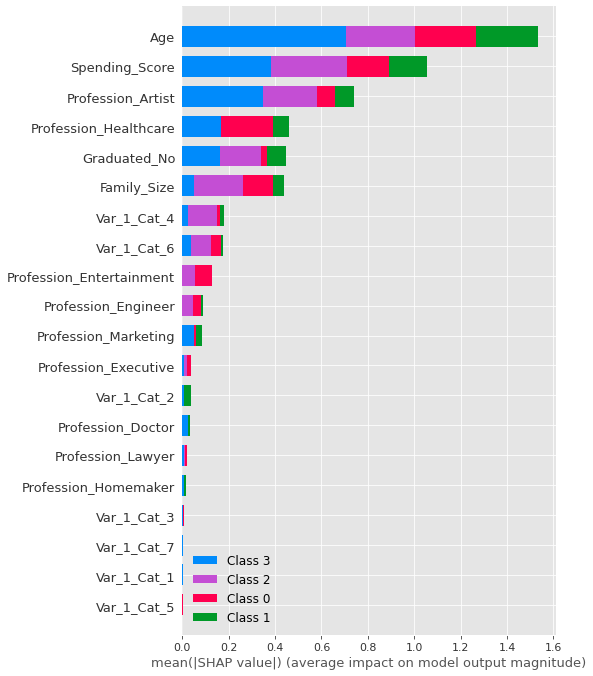

In [56]:
## XBGM Shap Value ##
shap.initjs()
shap.summary_plot(shap_xgb, X_train)

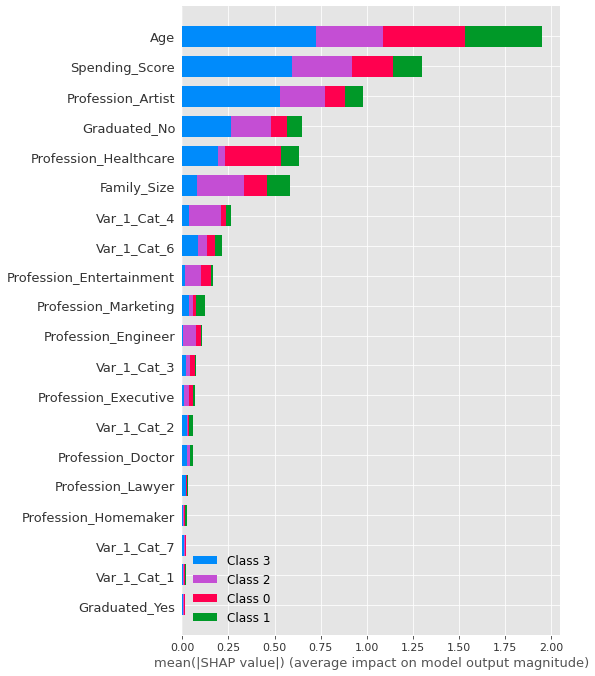

In [57]:
## LGBM Shap Value ##
shap.initjs()
shap.summary_plot(shap_lgbm, X_train)

# Interim Summary - 2
* In all three ways, I found that ['Age','Profession','Spending_Score'] is most important fatures

* I'm going to delete the bottom three variants expecting model performance up... (Depreciated Column : Ever_Married, Gender, Work_Experience)

In [ ]:
# ################################
# # Delete Three bottom Variants #
# ################################

# ## Train Dataset

# df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
# df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

# df_train['Family_Size'] = df_train['Family_Size'].astype('object')
# df_test['Family_Size'] = df_test['Family_Size'].astype('object')

# df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
# df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

# ## Remove ID column
# df_train.drop('ID', axis=1, inplace=True)
# df_test.drop('ID', axis=1, inplace=True)

# be_value = {}

# for i in df_train.columns :    
#     mode_value = df_train[i].mode()[0]
#     be_value[i] = mode_value

# df_train.fillna(value = be_value, inplace = True)

# ## Test Dataset

# be_value = {}

# for i in df_test.columns :
#     mode_value = df_test[i].mode()[0]
#     be_value[i] = mode_value

# df_test.fillna(value = be_value, inplace = True)


# ### Train Data ###
# seq_cols = ['Family_Size','Spending_Score'] ## including Target Variable
# non_seq_cols = ['Graduated','Profession','Var_1']

# ## oe Encoder
# df_oe_tr = df_train[seq_cols]
# oe = OrdinalEncoder()
# df_oe_tr = oe.fit_transform(df_oe_tr)
# df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

# ## for target data Encoding
# target_oe = OrdinalEncoder()
# oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
# oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])

# from category_encoders import OneHotEncoder

# ## ohe Encoder
# df_ohe_tr = df_train[non_seq_cols]
# ohe = OneHotEncoder(use_cat_names = True)
# df_ohe_tr = ohe.fit_transform(df_ohe_tr)

# mm = MinMaxScaler()
# scd_age_tr = mm.fit_transform(df_train[['Age']])
# scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

# scd_age_test = mm.transform(df_test[['Age']])
# scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])


# seq_cols = ['Family_Size','Spending_Score'] 
# non_seq_cols = ['Graduated','Profession','Var_1']


# ### Test Data ###
# ## oe Encoder
# df_oe_test = df_test[seq_cols]
# df_oe_test = oe.transform(df_oe_test)
# df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

# ## ohe Encoder
# df_ohe_test = df_test[non_seq_cols]
# df_ohe_test = ohe.transform(df_ohe_test)

# fin_df_train = pd.concat([df_oe_tr,df_ohe_tr,scd_age_tr ,oe_target_tr], axis=1)
# fin_df_test = pd.concat([df_oe_test,df_ohe_test, scd_age_test], axis=1)

# features = fin_df_train.drop(['Segmentation'], axis=1)
# target = fin_df_train['Segmentation']


# lgbm_clf = LGBMClassifier() ## use default parameters to test our pre-processing and feature importance

# scores = cross_val_score(lgbm_clf, features, target, cv=5, scoring='accuracy' )

# print(f'Mean Score : {np.mean(scores)*100:.2f}%')



* But althogh it is very few score, the test score is got lower than before! So I don't think it is not efficient to delete columns 
* I think it is because the high correlation between "Ever_Married" and "Spending_Score" affected that result

# Hyper Paratemer Tuning
* I pass this process because it is hard to expect the huge performance improvements with hyper parameter tuning  
* And this process usually takes a lot of time...!! 

# Inference - 1

In [59]:
tr_df, test_df = preprocessing()

sub = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/sample_submission.csv')

features = tr_df.drop(['Segmentation'], axis=1)
target = tr_df['Segmentation']

lgbm_clf.fit(X_train, y_train)

## Inference
preds = lgbm_clf.predict(test_df)
sub['Predict'] = preds
for idx,i in enumerate(sub['Predict']) :
    if i == 0.0 :
        sub['Predict'][idx] = 'A'
    elif i ==1.0 :
        sub['Predict'][idx] = 'B'
    elif i == 2.0 :
        sub['Predict'][idx] = 'C'
    else :
        sub['Predict'][idx] = 'D'



In [ ]:
cor = len(sub[sub['Segmentation'] == sub['Predict']])

inference_acc = cor /len(sub)
inference_acc*100

In [61]:
# 토요일에 할 거 : 이거 끝내기 (~pycaret까지해서 성능비교 해보기)
# 일요일에 할 거 : 이거 PCA, Clustering, t-sne로 해보기 (찍먹)

# Detecting Something Strange

## I fond something Strange... because the test dataset is composed with train dataset (ID)
## This means that we have to inference only 295 data points

In [62]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

In [63]:
print('# of Original test dataset',len(df_test['ID']))
print('# of Unique test dataset',len(set(df_test['ID'].values) - set(df_train['ID'])))
unique_ID = set(df_test['ID'].values) - set(df_train['ID'])

# of Original test dataset 2627
# of Unique test dataset 295


In [65]:
inference_data = df_test[df_test['ID'].isin(unique_ID)].reset_index(drop=True)

In [66]:
inference_data

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,459005,Male,Yes,61,Yes,Doctor,5.0,Low,3.0,Cat_6
1,459045,Female,Yes,88,Yes,Lawyer,1.0,Average,4.0,Cat_6
2,459090,Male,No,31,No,Artist,1.0,Low,2.0,Cat_6
3,459116,Male,Yes,60,Yes,Artist,2.0,Average,5.0,Cat_6
4,459121,Female,Yes,51,Yes,Artist,3.0,Average,6.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
290,467913,Male,Yes,48,Yes,Artist,3.0,Low,1.0,Cat_6
291,467930,Male,Yes,45,Yes,Entertainment,4.0,Average,2.0,Cat_6
292,467938,Male,Yes,46,Yes,Entertainment,5.0,Low,1.0,Cat_2
293,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6


# Inference -2

In [67]:
df_test = inference_data

df_train['Family_Size'] = df_train['Family_Size'].astype('object')
df_test['Family_Size'] = df_test['Family_Size'].astype('object')

df_train['Work_Experience'] = df_train['Work_Experience'].astype('object')
df_test['Work_Experience'] = df_test['Work_Experience'].astype('object')

## Remove ID column
df_train.drop('ID', axis=1, inplace=True)
df_test.drop('ID', axis=1, inplace=True)

be_value = {}

for i in df_train.columns :    
    mode_value = df_train[i].mode()[0]
    be_value[i] = mode_value

df_train.fillna(value = be_value, inplace = True)

## Test Dataset

be_value = {}

for i in df_test.columns :
    mode_value = df_test[i].mode()[0]
    be_value[i] = mode_value

df_test.fillna(value = be_value, inplace = True)


### Train Data ###
seq_cols = ['Family_Size','Spending_Score'] ## including Target Variable
non_seq_cols = ['Graduated','Profession','Var_1']

## oe Encoder
df_oe_tr = df_train[seq_cols]
oe = OrdinalEncoder()
df_oe_tr = oe.fit_transform(df_oe_tr)
df_oe_tr = pd.DataFrame(df_oe_tr, columns = seq_cols, dtype='int32')

## for target data Encoding
target_oe = OrdinalEncoder()
oe_target_tr = target_oe.fit_transform(df_train[['Segmentation']])
oe_target_tr = pd.DataFrame(oe_target_tr, columns = ['Segmentation'])

from category_encoders import OneHotEncoder

## ohe Encoder
df_ohe_tr = df_train[non_seq_cols]
ohe = OneHotEncoder(use_cat_names = True)
df_ohe_tr = ohe.fit_transform(df_ohe_tr)

mm = MinMaxScaler()
scd_age_tr = mm.fit_transform(df_train[['Age']])
scd_age_tr = pd.DataFrame(scd_age_tr, columns =['Age'])

scd_age_test = mm.transform(df_test[['Age']])
scd_age_test = pd.DataFrame(scd_age_test, columns = ['Age'])


seq_cols = ['Family_Size','Spending_Score'] 
non_seq_cols = ['Graduated','Profession','Var_1']


### Test Data ###
## oe Encoder
df_oe_test = df_test[seq_cols]
df_oe_test = oe.transform(df_oe_test)
df_oe_test = pd.DataFrame(df_oe_test, columns = seq_cols, dtype='int32')

## ohe Encoder
df_ohe_test = df_test[non_seq_cols]
df_ohe_test = ohe.transform(df_ohe_test)

fin_df_train = pd.concat([df_oe_tr,df_ohe_tr,scd_age_tr ,oe_target_tr], axis=1)
ID_fin_df_test = pd.concat([df_oe_test,df_ohe_test, scd_age_test], axis=1)

ID_fin_df_test

,Family_Size,Spending_Score,Graduated_No,Graduated_Yes,Profession_Healthcare,Profession_Engineer,Profession_Lawyer,Profession_Entertainment,Profession_Artist,Profession_Executive,...,Profession_Homemaker,Profession_Marketing,Var_1_Cat_4,Var_1_Cat_6,Var_1_Cat_7,Var_1_Cat_3,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_5,Age
0,2,2,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.605634
1,3,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.985915
2,1,2,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.183099
3,4,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.591549
4,5,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.464789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0,2,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0.422535
291,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.380282
292,0,2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.394366
293,1,2,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.492958


In [ ]:
preds = lgbm_clf.predict(ID_fin_df_test)

sub_ID = sub[sub['ID'].isin(unique_ID)].reset_index(drop=True)

sub_ID['Predict_2'] = preds
 


for idx,i in enumerate(sub_ID['Predict_2']) :
    if i == 0.0 :
        sub_ID['Predict_2'][idx] = 'A'
    elif i ==1.0 :
        sub_ID['Predict_2'][idx] = 'B'
    elif i == 2.0 :
        sub_ID['Predict_2'][idx] = 'C'
    else :
        sub_ID['Predict_2'][idx] = 'D'

sub_ID

In [ ]:
cor = len(sub_ID[sub_ID['Segmentation'] == sub_ID['Predict_2']])

inference_acc = cor /len(sub_ID)
inference_acc*100

# Conclusion
* The purposes of this mini project are..
    1. Re-learning the sense of ML Pipeline
    2. Using Pycaret for the first time in forever
    3. Using more Feature Selection Advisors(+Shap Value)
  
* And I learnd one more important thing... sometimes it is not good to ignore 'columns look like index' 
* At First, I ignored ID column but it was a 'key-column' of this dataset. Because it had informations about the Data Leakage
  


## And The submission file's lable is not correct lable set. because it is all filled with only 'A'
## So I can not measure the performance accurately :(

## But the top 5 rankers model performance is similar to me and their submission's lable is almost same with me !! So I think it is not that big problem

# Using Pycaret

In [ ]:
!pip install pycaret

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Train.csv')
df_test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Marketing Segmentation/Marketing/Test.csv')

from pycaret.classification import *

setup_clf = setup(df_train, target='Segmentation')



In [ ]:
lgbm = create_model('lightgbm', fold=5)

In [ ]:
top5 = compare_models(sort='Accuracy', n_select=5)

In [ ]:
tuned_top5 = [tune_model(i) for i in top5]

In [ ]:
blender_top5 = blend_models(estimator_list=tuned_top5)

In [ ]:
final_model = finalize_model(blender_top5)
prediction = predict_model(final_model, data=ID_fin_df_test)